In [1]:
## import
import lamindb as ln
import scanpy as sc

from scprint import scPrint

from scdataloader.data import SimpleAnnDataset
from scdataloader import Preprocessor, Collator

from torch.utils.data import DataLoader

from scdataloader.utils import load_genes

import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker

from lightning.pytorch import Trainer

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 lamindb instance: jkobject/scprint


2024-02-20 15:35:10,485:INFO - Created a temporary directory at /tmp/tmp36d24frx
2024-02-20 15:35:10,488:INFO - Writing /tmp/tmp36d24frx/_remote_module_non_scriptable.py


## preparing the model

In [4]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/iuealg88/checkpoints/epoch=0-step=13068.ckpt', strict=False, precpt_gene_emb = '../../data/temp/embeddings.parquet') #effortless-night-21


scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 128)
    (enc_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expr_encoder): ContinuousValueEncoder(
    (linear1): Linear(in_features=1, out_features=128, bias=True)
    (activation): ReLU()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 128)
    (enc_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (time_encoder): ContinuousValueEncoder(
    (linear1): Linear(in_features=1, out_features=128, bias=True)
    (activation): ReLU()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): FlashTransformerEncoder(
    (blocks): ModuleList(
  

In [5]:
ensembl = load_genes(['NCBITaxon:9606'])
ensembl['ensembl_gene_id'] = ensembl.index

## Loading the data

In [ ]:
adata.sc.read(
  only dataset dropped
)

In [6]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


  0%|          | 0.00/301M [00:00<?, ?B/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [19]:
#adata = sc.read(
#    "data/lung_atlas.h5ad",
#    backup_url="https://figshare.com/ndownloader/files/24539942",
#)

In [20]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad')

In [21]:
Preprocessor()(adata.copy())
# cannot preprocess (first of all not raw counts and also doesn't have standardized values)

ValueError: Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess

In [7]:
# You need to use counts
adata.X = adata.layers['counts']
del adata.layers

In [8]:
# you need to have ensembl gene ids 
# # removing the other ones
var = adata.var.merge(ensembl.drop_duplicates('symbol').set_index('symbol', drop=False), left_index=True, right_index=True, how='inner').sort_values(by="ensembl_gene_id").set_index('ensembl_gene_id')
adata = adata[:, var['symbol']]
adata.var = var

# adding back the missing genes
unseen = set(ensembl.index) - set(adata.var.index)
# adding them to adata
emptyda = ad.AnnData(
    csr_matrix((adata.shape[0], len(unseen)), dtype=np.float32),
    var=pd.DataFrame(index=list(unseen)),
    obs=pd.DataFrame(index=adata.obs.index),
)
adata = ad.concat([adata, emptyda], axis=1, join="outer", merge="only")
# do a validation function
adata.uns["unseen_genes"] = list(unseen)
adata = adata[:, adata.var.sort_index().index]

# Add at least the organism you are working with
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata

/tmp/ipykernel_1390162/632984386.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"


AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [64]:
adataset = SimpleAnnDataset(adata, obs_to_output=['organism_ontology_term_id'])
col = Collator(organisms=["NCBITaxon:9606",], valid_genes=model.genes, how="most expr", max_len=1000,add_zero_genes=100)#mdataset.encoder['organism_ontology_term_id'])
dataloader = DataLoader(adataset, collate_fn=col, batch_size=128, num_workers=2, shuffle=False)

In [29]:
#from scdataloader import AnnDataCollator
#from anndata.experimental import AnnLoader
#dataloader = AnnLoader([adata], collate_fn=AnnDataCollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 'NCBITaxon:9606'}, how="most expr", logp1=True), batch_size=32, num_workers=4)

In [10]:
trainer = Trainer(precision=16)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-02-20 16:07:06,122:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-20 16:07:06,144:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-20 16:07:06,148:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-20 16:07:06,152:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-20 16:07:06,155:INFO - HPU available: False, using: 0 HPUs


In [13]:
model.labels, model.pred_embedding

(['cell_type_ontology_term_id',
  'disease_ontology_term_id',
  'assay_ontology_term_id',
  'self_reported_ethnicity_ontology_term_id',
  'sex_ontology_term_id',
  'organism_ontology_term_id'],
 ['cell_type_ontology_term_id',
  'disease_ontology_term_id',
  'self_reported_ethnicity_ontology_term_id',
  'sex_ontology_term_id'])

In [12]:
model.pred_embedding = [
    "cell_type_ontology_term_id",
    "disease_ontology_term_id",
    "self_reported_ethnicity_ontology_term_id",
    "sex_ontology_term_id",
]

In [20]:
adata.obs['tech'].value_counts()


inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

In [21]:
adata.obs.celltype.value_counts()

alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: celltype, dtype: int64

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-20 17:26:30,709:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10112 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

couldn't log to tensorboard
couldn't log to wandb


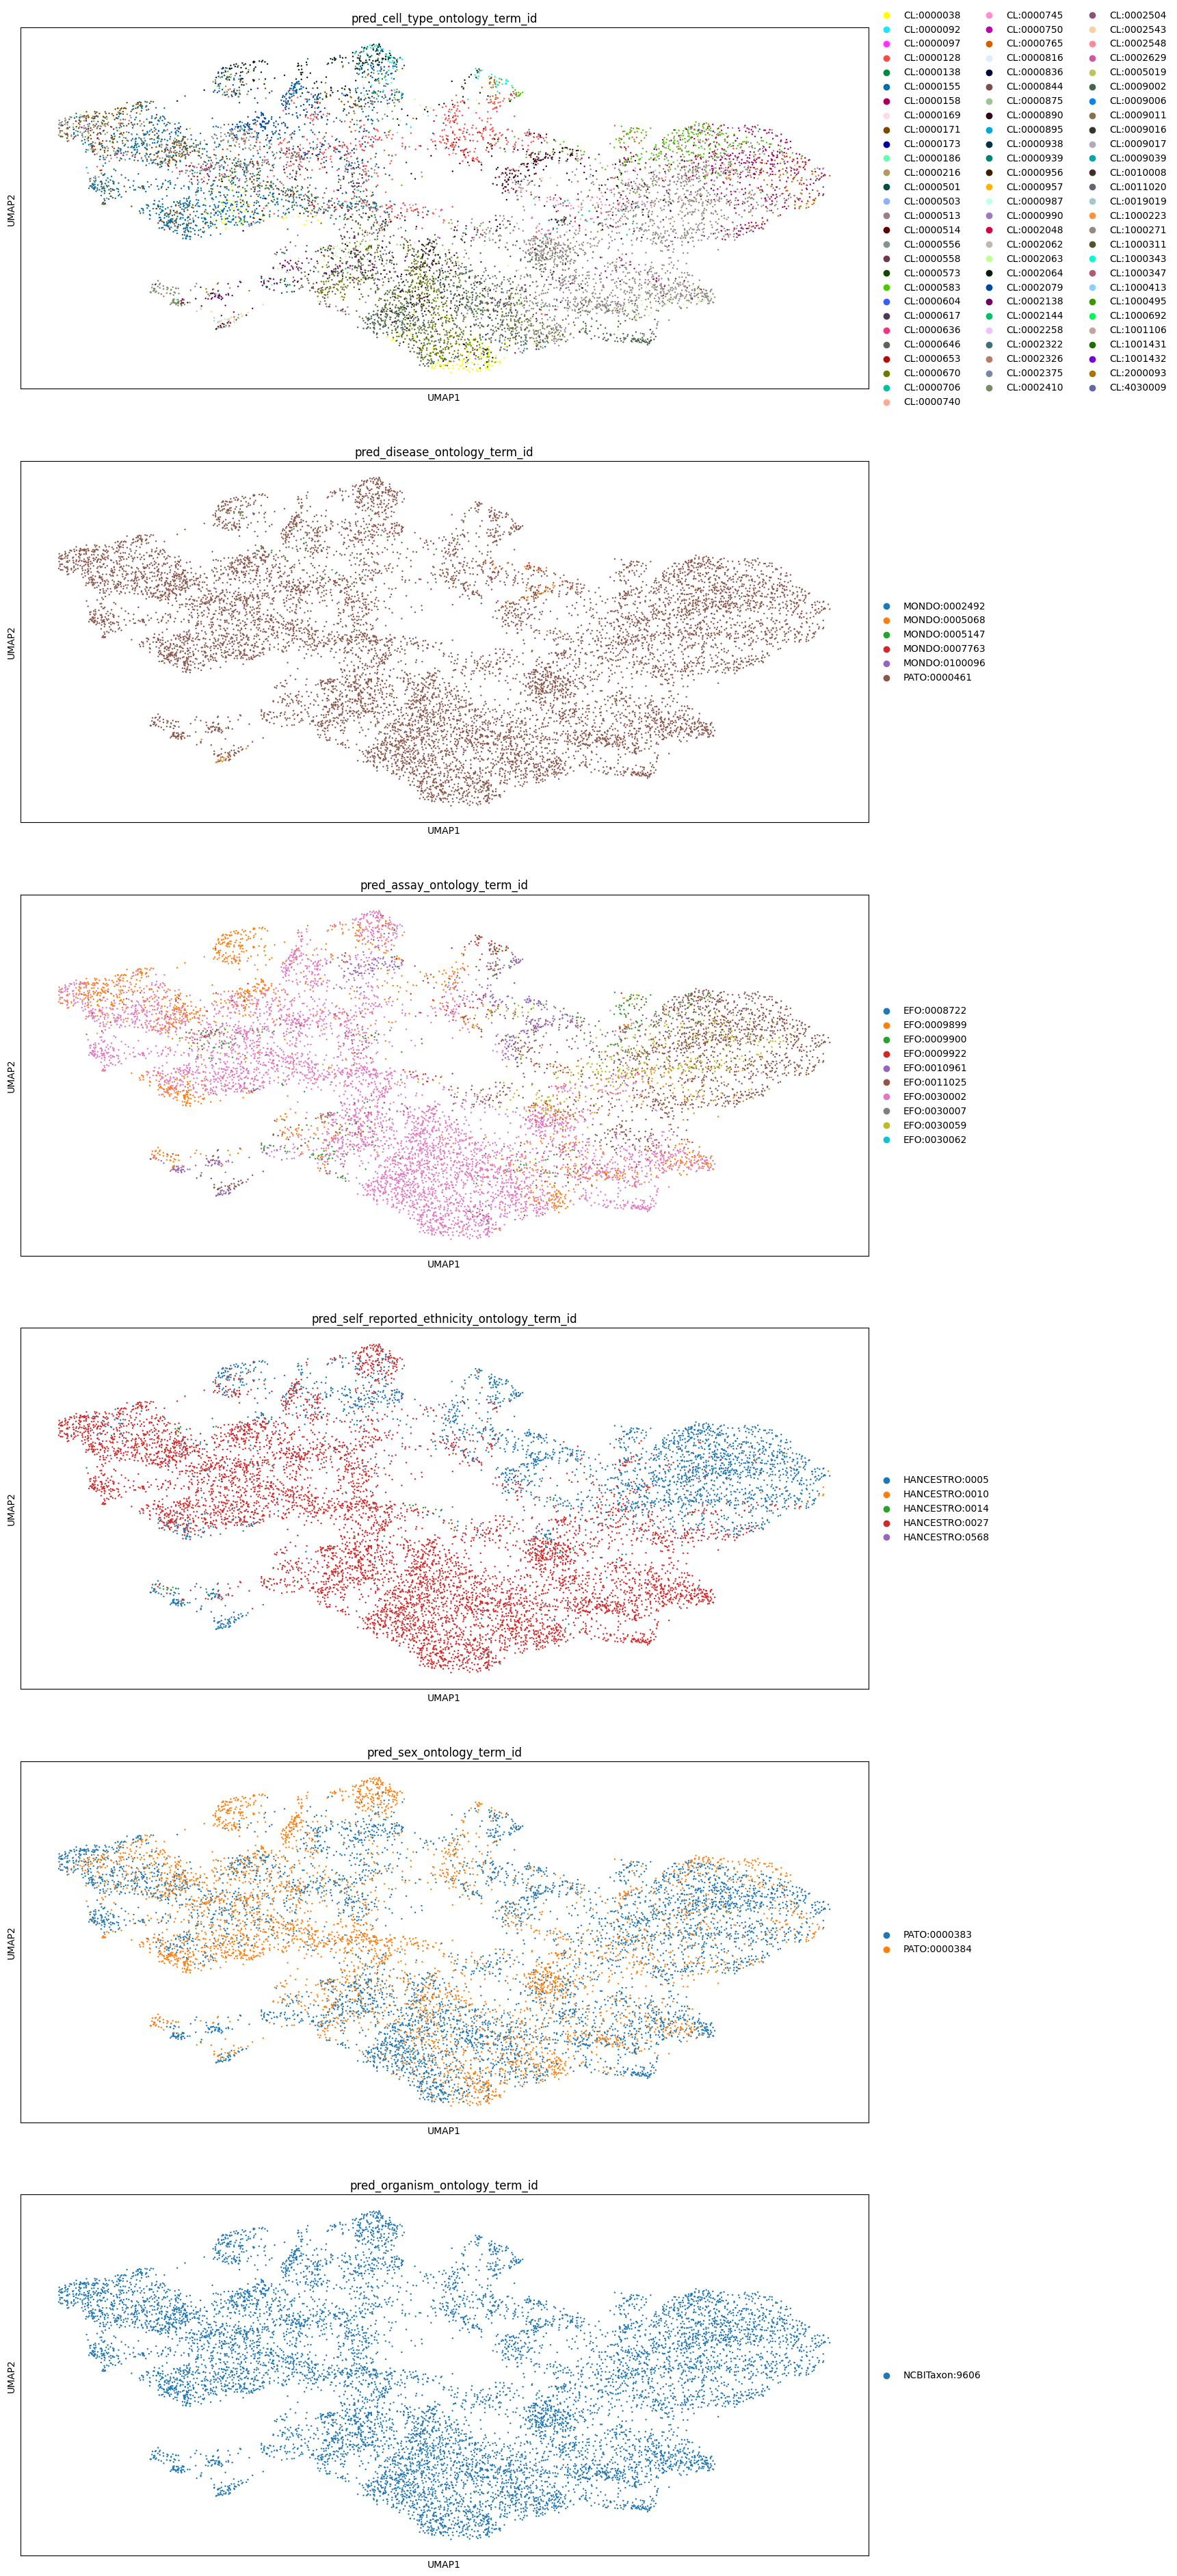

In [65]:
predictions = trainer.predict(model, dataloader)

In [66]:
pred_adata = sc.read_h5ad(
    (model.logger.save_dir if model.logger is not None else ".")
    + "/step_"
    + str(model.global_step)
    + "_umap_"
    + ".h5ad"
)

In [16]:
pred_adata.obs

pred_cell_type_ontology_term_id pred_disease_ontology_term_id  \
0                          CL:0000171                  PATO:0000461   
1                          CL:0000765                  PATO:0000461   
2                          CL:0000171                  PATO:0000461   
3                          CL:0000155                  PATO:0000461   
4                          CL:1000271                  PATO:0000461   
...                               ...                           ...   
10011                      CL:0000155                  PATO:0000461   
10012                      CL:1000343                  PATO:0000461   
10013                      CL:0002064                  PATO:0000461   
10014                      CL:0002064                  PATO:0000461   
10015                      CL:0002064                  PATO:0000461   

      pred_assay_ontology_term_id  \
0                     EFO:0030002   
1                     EFO:0030002   
2                     EFO:0009899   
3                     EFO:0030002   
4                     EFO:0011025   
...                           ...   
10011                 EFO:0030002   
10012                 EFO:0009899   
10013                 EFO:0009899   
10014                 EFO:0009899   
10015                 EFO:0030002   

      pred_self_reported_ethnicity_ontology_term_id pred_sex_ontology_term_id  \
0                                    HANCESTRO:0027              PATO:0000383   
1                                    HANCESTRO:0027              PATO:0000384   
2                                    HANCESTRO:0005              PATO:0000384   
3                                    HANCESTRO:0027              PATO:0000384   
4                                    HANCESTRO:0027              PATO:0000383   
...                                             ...                       ...   
10011                                HANCESTRO:0027              PATO:0000383   
10012                                HANCESTRO:0005              PATO:0000384   
10013                                HANCESTRO:0005              PATO:0000384   
10014                                HANCESTRO:0005              PATO:0000384   
10015                                HANCESTRO:0027              PATO:0000384   

      pred_organism_ontology_term_id leiden  
0                     NCBITaxon:9606     13  
1                     NCBITaxon:9606      1  
2                     NCBITaxon:9606      1  
3                     NCBITaxon:9606      1  
4                     NCBITaxon:9606      6  
...                              ...    ...  
10011                 NCBITaxon:9606      0  
10012                 NCBITaxon:9606     15  
10013                 NCBITaxon:9606     15  
10014                 NCBITaxon:9606     15  
10015                 NCBITaxon:9606     15  

[10016 rows x 7 columns]

In [67]:
expr = np.array(model.expr_pred[0])

In [68]:
expr.shape

array([[131.65997   ,  29.549952  ,  19.607767  , ...,   1.1995907 ,
          7.7010403 ,   0.73472875],
       [352.7837    ,  88.84994   ,  61.664867  , ...,   8.065009  ,
          1.6457222 ,   1.1151838 ],
       [179.33528   ,  57.207157  ,  43.435993  , ...,   3.1727197 ,
          2.1062756 ,   0.9593918 ],
       ...,
       [223.08798   , 118.48114   ,  54.776947  , ...,   1.082682  ,
          1.2685677 ,   2.6607585 ],
       [130.19698   ,  97.51303   ,  44.644714  , ...,   3.5467129 ,
          2.2846248 ,   0.8338242 ],
       [184.8851    ,  42.39703   ,  12.98097   , ...,  40.693264  ,
         37.05164   ,   2.698467  ]], dtype=float32)

In [69]:
expr = np.array(model.expr_pred[0])

expr[np.random.binomial(1, p=np.array(torch.nn.functional.sigmoid(model.expr_pred[2].to(torch.float32)))).astype(bool)] = 0

#expr[expr<=0.5] = 0
#expr[(expr<=1) & (expr>0.5)] = 1

In [70]:
for i in dataloader:
    print(i["x"].shape)
    break

torch.Size([128, 1100])


In [50]:
size = 128

In [71]:
expr[:size].mean(), expr[:size].max(), (expr[:size]==0).sum()

(3.9165297, 923.2358, 899)

In [72]:
i['x'].mean(), i['x'].max(), (i['x']==0).sum()

(tensor(5.8350), tensor(1597.0111), tensor(11357))

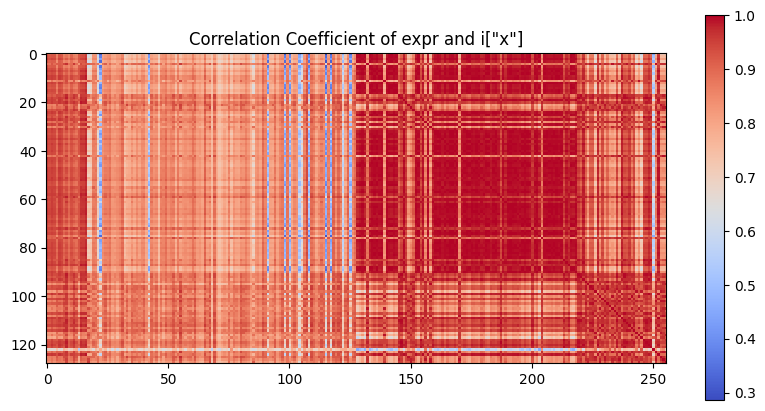

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:size], i['x'])[size:, :]

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()

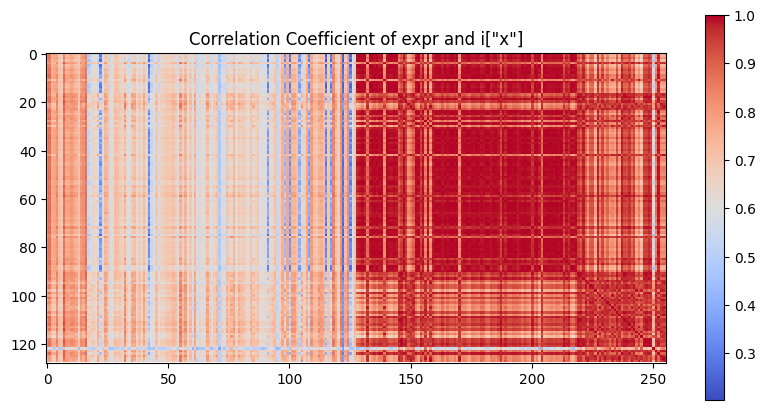

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:size], i['x'])[size:, :]

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()


In [77]:
pred_adata

AnnData object with n_obs × n_vars = 10112 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'leiden', 'neighbors', 'pred_assay_ontology_term_id_colors', 'pred_cell_type_ontology_term_id_colors', 'pred_disease_ontology_term_id_colors', 'pred_organism_ontology_term_id_colors', 'pred_self_reported_ethnicity_ontology_term_id_colors', 'pred_sex_ontology_term_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [19]:
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [78]:
subadata = adata[:10112] # 10016

In [75]:
sc.pp.pca(subadata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [80]:
pred_adata.obs.index = subadata.obs.index
subadata.obsm["Unintegrated"] = subadata.obsm["X_pca"]
subadata.obsm["X_umap"] = pred_adata.obsm["X_umap"]
subadata.obsm["scprint"] = pred_adata.X
pred_adata.obs.index = subadata.obs.index
subadata.obs = pd.concat([subadata.obs, pred_adata.obs], axis=1)


/tmp/ipykernel_1390162/1835330950.py:3: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  subadata.obsm["X_umap"] = pred_adata.obsm["X_umap"]


In [81]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000171"].celltype.value_counts() #type A

alpha                 210
beta                  169
acinar                 41
gamma                  22
ductal                 21
delta                  18
macrophage              2
activated_stellate      1
epsilon                 1
quiescent_stellate      1
endothelial             0
mast                    0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

In [33]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000171"].celltype.value_counts() #type A

alpha                 221
beta                  164
ductal                 84
acinar                 26
gamma                  23
endothelial            16
delta                  12
quiescent_stellate      5
activated_stellate      4
macrophage              3
epsilon                 2
mast                    0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

In [82]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000169"].celltype.value_counts() #typeB

beta                  23
delta                  5
acinar                 3
alpha                  2
activated_stellate     0
ductal                 0
endothelial            0
epsilon                0
gamma                  0
macrophage             0
mast                   0
quiescent_stellate     0
schwann                0
t_cell                 0
Name: celltype, dtype: int64

In [32]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000169"].celltype.value_counts() #typeB

beta                  715
alpha                 399
delta                 142
gamma                  37
acinar                 24
ductal                  7
activated_stellate      2
epsilon                 2
endothelial             0
macrophage              0
mast                    0
quiescent_stellate      0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

In [83]:
subadata.obs.loc[subadata.obs.celltype=="alpha", ['pred_cell_type_ontology_term_id']].value_counts().head(10)

pred_cell_type_ontology_term_id
CL:1000271                         1096
CL:0009002                          562
CL:0000158                          383
CL:0000171                          210
CL:0000155                          195
CL:0000583                          176
CL:0000670                          127
CL:0000890                          113
CL:0000765                           77
CL:0002063                           47
dtype: int64

In [ ]:
subadata.obs.loc[subadata.obs.celltype=="acinar", ['pred_cell_type_ontology_term_id']].value_counts()

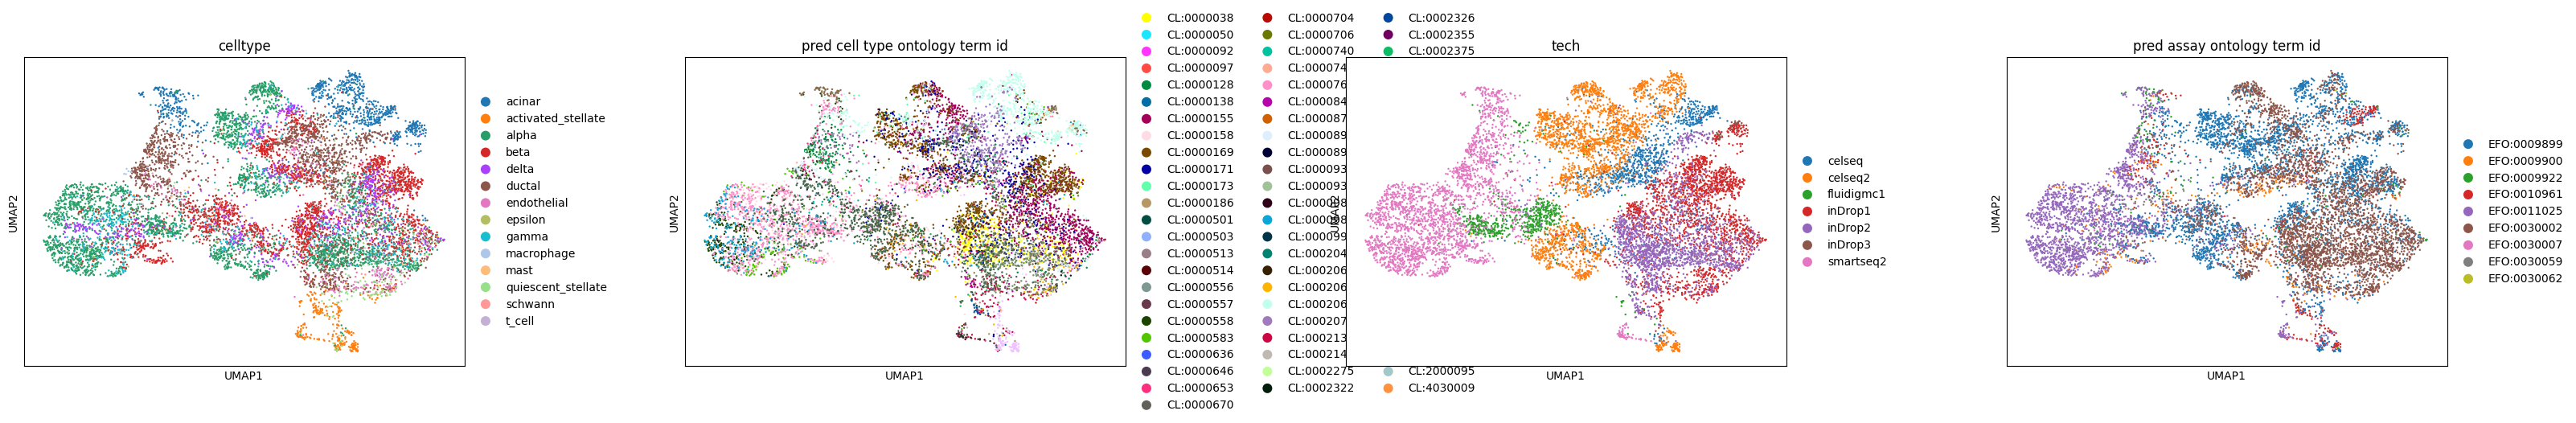

In [24]:
sc.pl.scatter(subadata, basis="umap", color=["celltype", "pred_cell_type_ontology_term_id", "tech", "pred_assay_ontology_term_id"])

In [84]:
bm = Benchmarker(
    subadata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["Unintegrated", "scprint"],
    n_jobs=6,
)
bm.benchmark()

KeyboardInterrupt: 

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


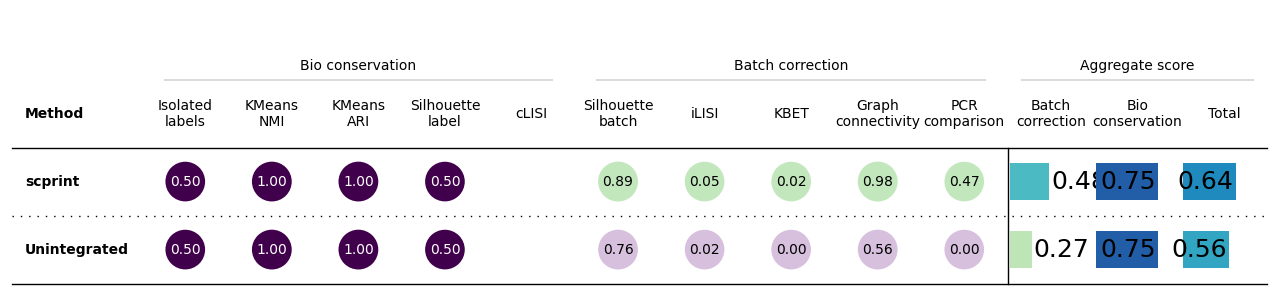

In [180]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
adata.X.iloc[0].to_array()

In [ ]:
model

## results from running it on most famous methods

![](https://scib-metrics.readthedocs.io/en/stable/_images/72bdb33d77de77ce505e24fef1d700c2b91985b1d3fcce1c2b1dd7a35c8a647f.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN